# AAFormer: Adaptive Agent Transformer for Few-shot Segmentation

**Paper authors:** Yuan Wang, Rui Sun, Zhe Zhang, Tianzhu Zhang

**Reproduced by:** Yusuf Soydan, Bartu Akyürek

This paper is about few-shot segmentation (FSS), aiming to segment objects in a given image and a set of support images with masks.

## Prepare Workspace


In [ ]:
!pip install POT
!pip install tqdm
!pip install torchinfo
!pip install matplotlib
!pip install tensorboard

In [2]:
# General Dependencies
%load_ext autoreload
%autoreload 2

import os
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from tqdm import tqdm

In [3]:
"""
Run from Colab or local
"""

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    ROOT_PATH = "/content/gdrive/MyDrive/AAFormer"
    DATA_PATH = os.path.join(ROOT_PATH, "Datasets")

    %cd ./gdrive/MyDrive/AAFormer
    !matplotlib inline

except:
    ROOT_PATH = os.curdir
    DATA_PATH = "../Datasets"
    # Note: If you are running this notebook on your local, please put the Datasets folder outside of current directory

In [4]:
# Source dependencies
from data.dataset import FSSDataset
from model.aaformer import AAFormer

from common.vis import Visualizer
from common.dice_loss import DiceLoss
from common.evaluation import Evaluator
from train.train import train


In [5]:
# HYPERPARAMETERS
# -----------------------------------------------------------------
# Note: the parameters with * comment are NOT provided by the paper
# TODO: make hyperparameters UPPER_CASE
image_resolution = 128 # 
reduce_dim = 256
c = 128             #   Hidden dimensions, According to paper: 328 
hw = 256            # * Dimensionality of Feature maps (depends on ResNet choice)
N = 16               # * Number of layers in Encoder/Decoder
heads = 8           # * Number of attention heads
num_tokens = 14     #   Number of Agent Tokens (see p.13, "Hyperparameter Evaluations"), According to paper: max. 14
sinkhorn_reg = 0.05 #   Regularization term of Optimal Transport, (see supplementary), According to paper: 0.05
max_iter_ot = 100    #   Maximum iterations of Optimal Transport algorithm, (see supplementary), According to paper: 10
shot = 1

batch_size = 4    # According to paper: 4
adam_lr = 1e-4    # According to paper: 0.0001
adam_decay = 1e-2 # According to paper: 0.01
num_epoch = 20    # According to paper: 200

# Additional parameters to control the flow
# ----------------------------------------------------------------
bypass_ot = False                         # To turn off OT module if it causes any problem (e.g. RAM failure)
use_dice_loss = True                      # False means use CrossEntropy loss
cuda = torch.cuda.is_available()          #
device = 'cuda' if cuda else 'cpu'        #
checkpoint = 100                          # Save the model every {checkpoint} iteration
use_original_imgsize = False



## Prepare PASCAL-$5^i$ Dataset

In [6]:
# STEP 1: Download PASCAL VOC2012 devkit (train/val data): (uncomment lines below)
# ------------------------------------------------------------------------------
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xvf 'VOCtrainval_11-May-2012.tar' -C ./Datasets/

# (or instead of wget, use directly the link to download)
# STEP 2: Place "VOC2012" folder from downloaded "VOCdevkit" folder under a "Datasets" folder.
# ------------------------------------------------------------------------------
#!mv Datasets/VOCdevkit/VOC2012 Datasets/VOC2012

# STEP 3: Download extended annotations from here
#!wget https://drive.google.com/file/d/10zxG2VExoEZUeyQl_uXga2OWHjGeZaf2/view

# STEP 4: Extract Put the downloaded extension under "Datasets/VOC2012/"


In [25]:
# Dataset initialization
OVERFIT = 1 # Make it -1 for original datasets, 0 for single class, 1 for single sample.

if OVERFIT == 1:
    batch_size = 1
    shot = 1

FSSDataset.initialize(img_size=image_resolution, datapath=DATA_PATH, use_original_imgsize=False)
dataloader_trn = FSSDataset.build_dataloader(benchmark='pascal', bsz=batch_size, shot=shot, nworker=1, fold=0, split='trn',overfit=OVERFIT)
dataloader_val = FSSDataset.build_dataloader(benchmark='pascal', bsz=batch_size, shot=shot, nworker=1, fold=0, split='val',overfit=OVERFIT)

Total (trn) images are : 4
Total (val) images are : 4


## Initialize Models

In [8]:
# Define AAFormer model

model = AAFormer(cuda = cuda,
                 c = c,
                 hw = hw,
                 N = N,
                 heads = heads,
                 num_tokens = num_tokens,
                 im_res=image_resolution,
                 reduce_dim=reduce_dim,
                 bypass_ot=bypass_ot,
                 sinkhorn_reg=sinkhorn_reg,
                 max_iter_ot=max_iter_ot)


# Optimzer
# ----------------------------------------------------------------
optimizer = {}                               # set after model set
optimizer["adamw"] = torch.optim.AdamW(model.parameters(), lr=adam_lr, weight_decay=adam_decay)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/bartu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:15<00:00, 6.82MB/s]


In [14]:
# Load a pre-trained model (or comment if you are going to train from scratch)
#model = torch.load("model_20230618_121129_0") 
    

## Training Loop

EPOCH 1:
iteration 1
  batch 1 loss: 0.712195634841919


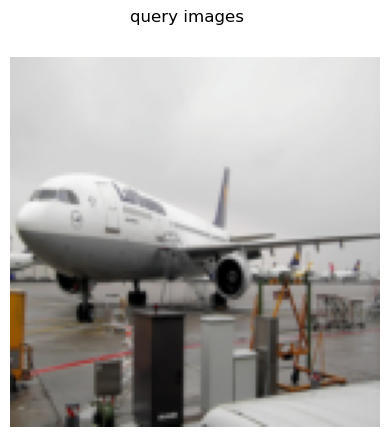

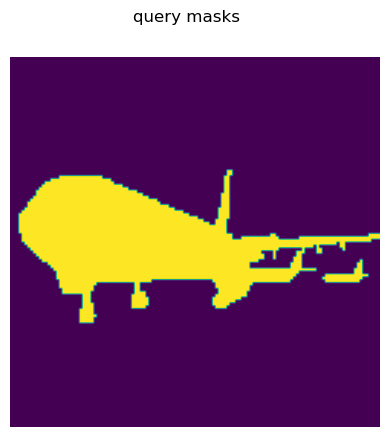

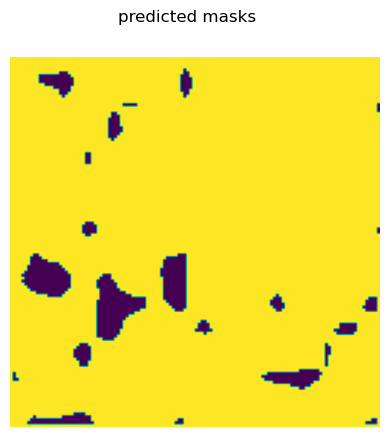

iteration 2
  batch 2 loss: 0.712195634841919


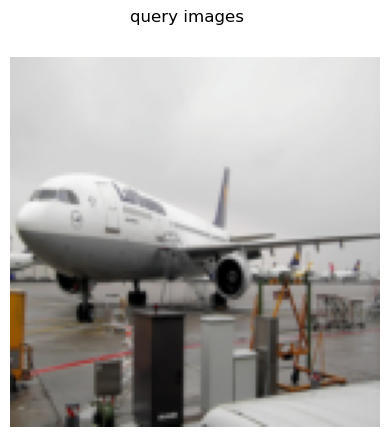

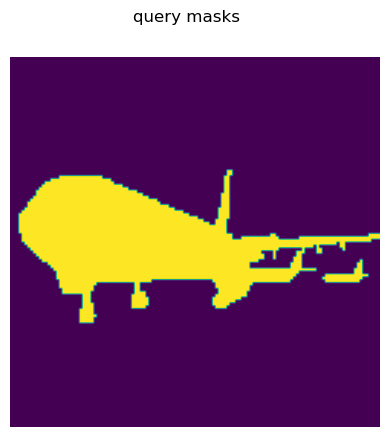

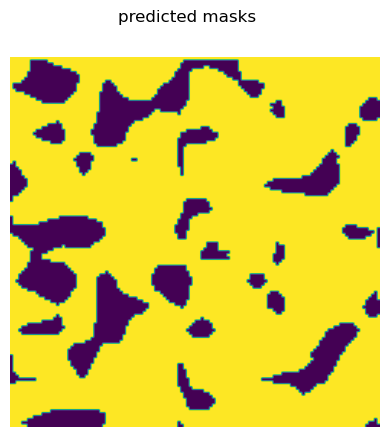

iteration 3
  batch 3 loss: 0.712195634841919


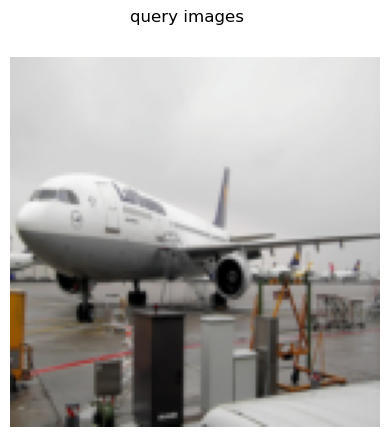

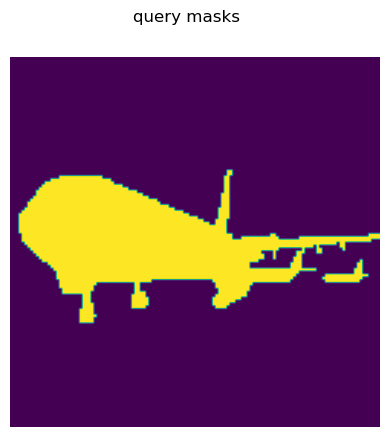

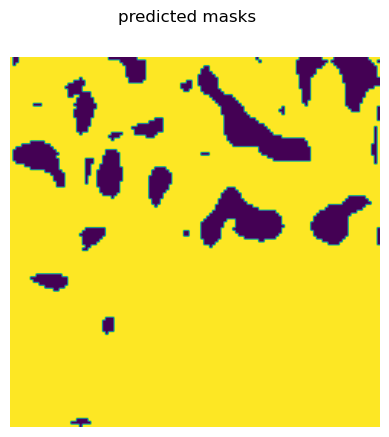

iteration 4
  batch 4 loss: 0.712195634841919


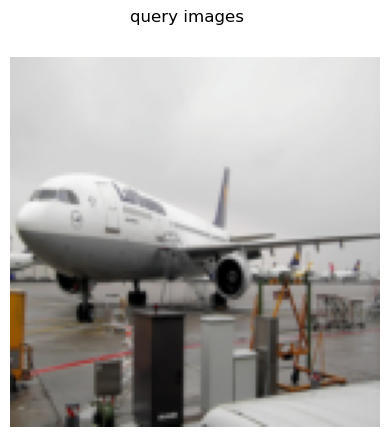

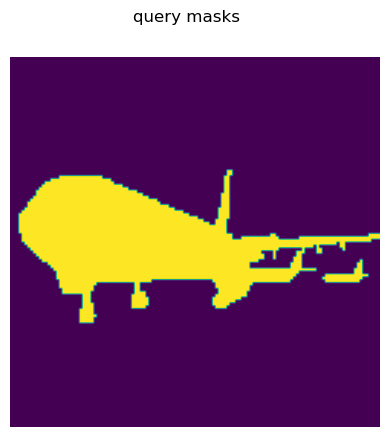

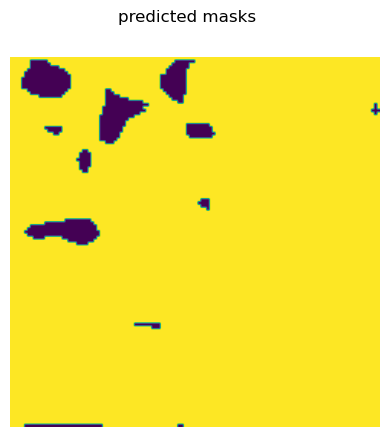

EPOCH 2:
iteration 1
  batch 1 loss: 0.712195634841919


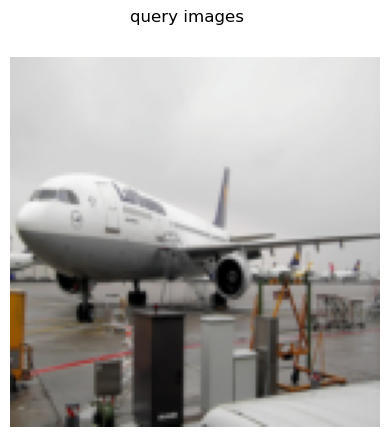

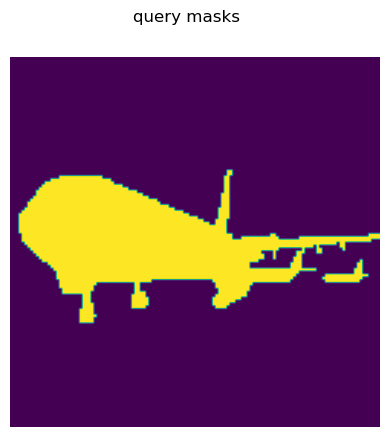

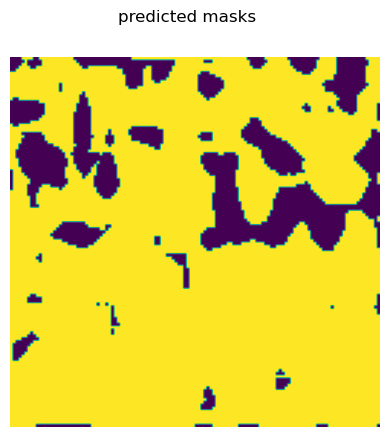

iteration 2
  batch 2 loss: 0.712195634841919


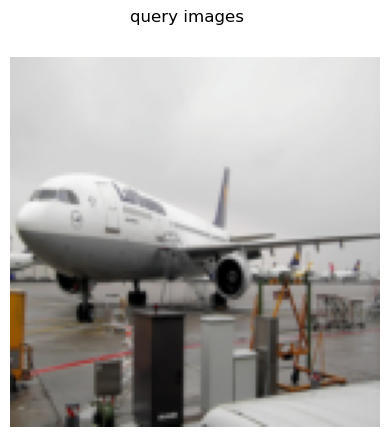

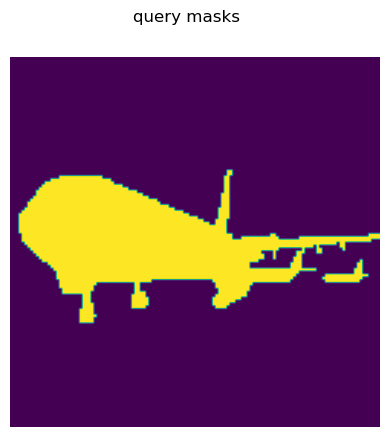

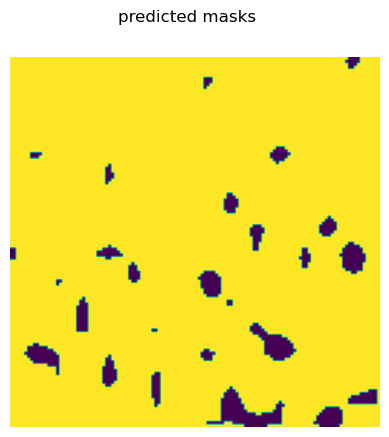

iteration 3
  batch 3 loss: 0.712195634841919


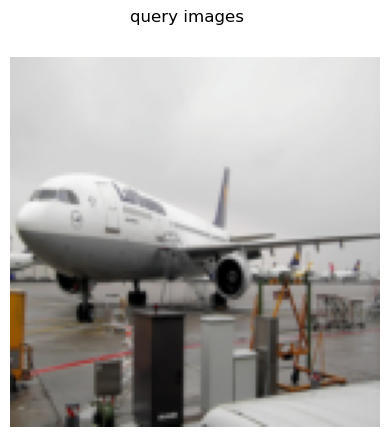

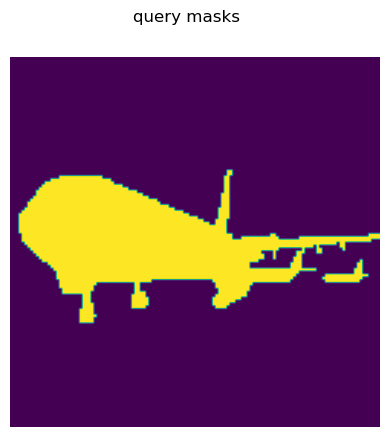

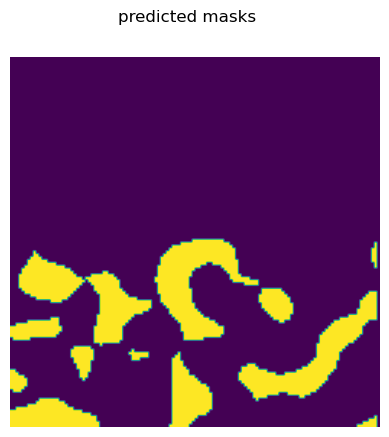

iteration 4
  batch 4 loss: 0.712195634841919


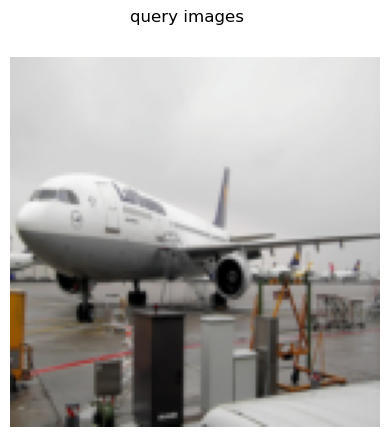

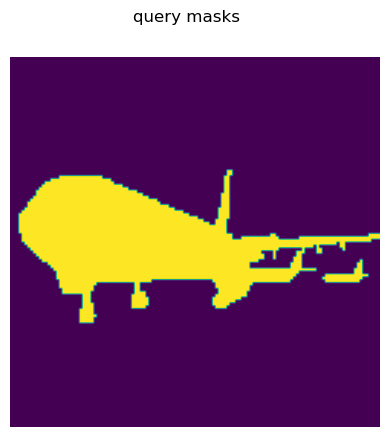

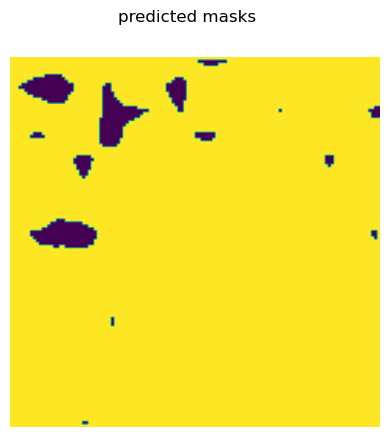

EPOCH 3:
iteration 1
  batch 1 loss: 0.712195634841919


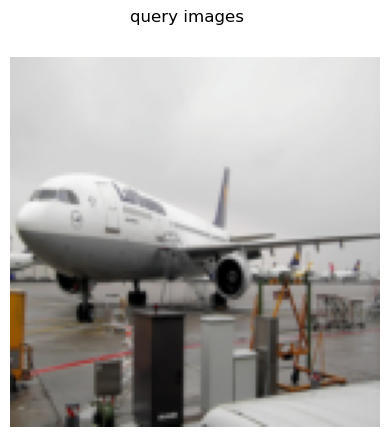

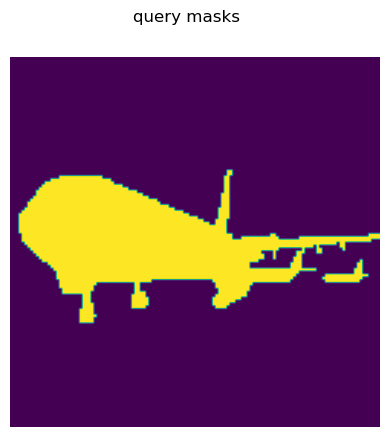

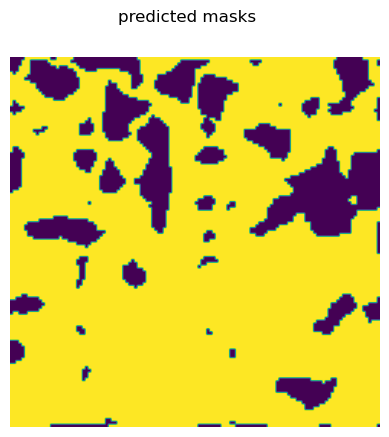

iteration 2
  batch 2 loss: 0.712195634841919


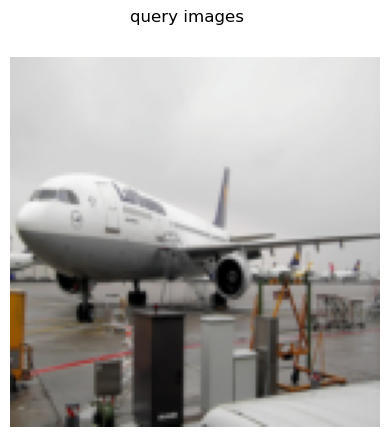

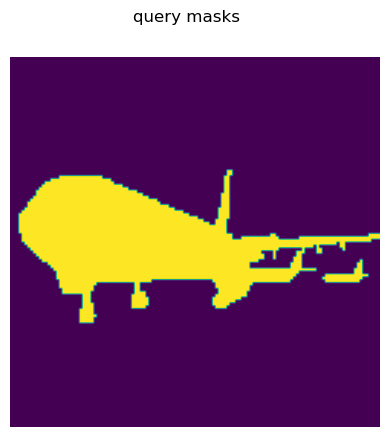

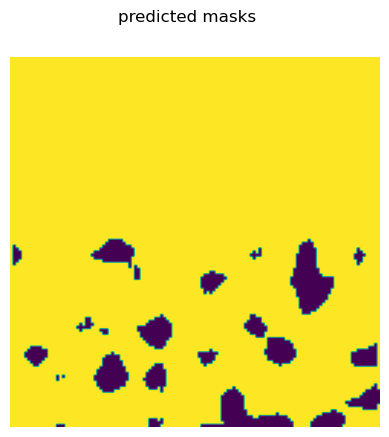

iteration 3
  batch 3 loss: 0.712195634841919


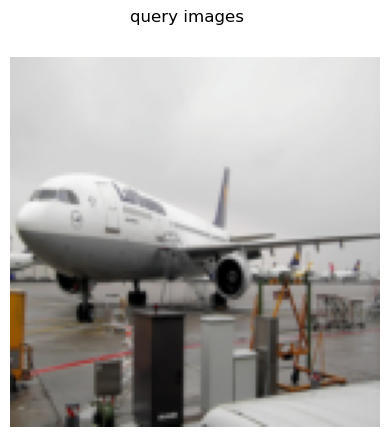

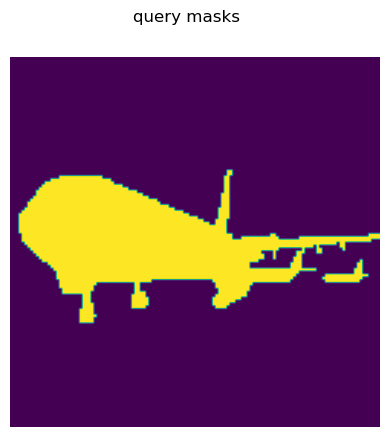

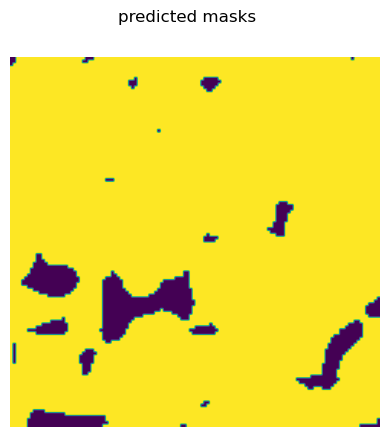

iteration 4
  batch 4 loss: 0.712195634841919


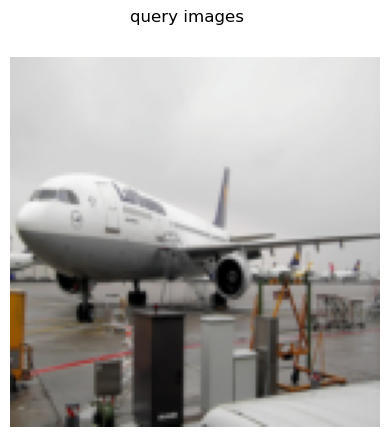

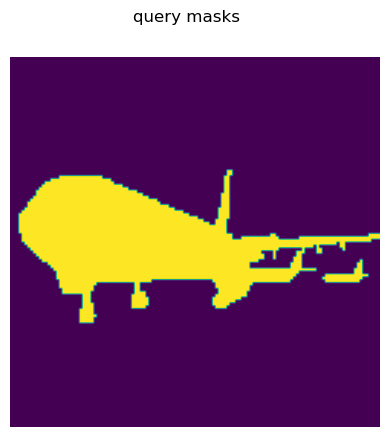

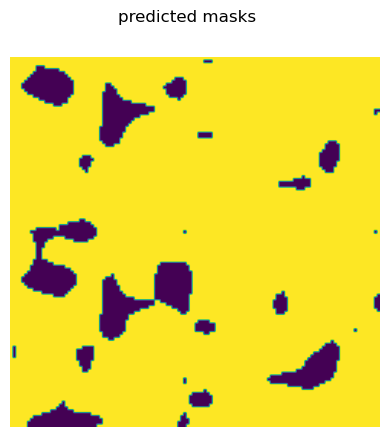

EPOCH 4:
iteration 1
  batch 1 loss: 0.712195634841919


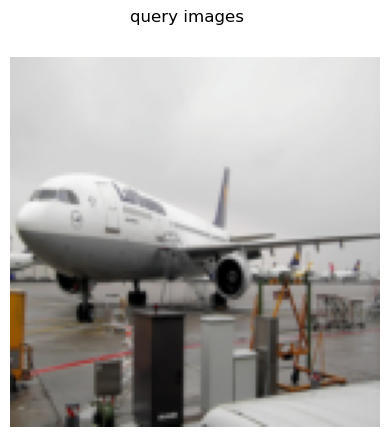

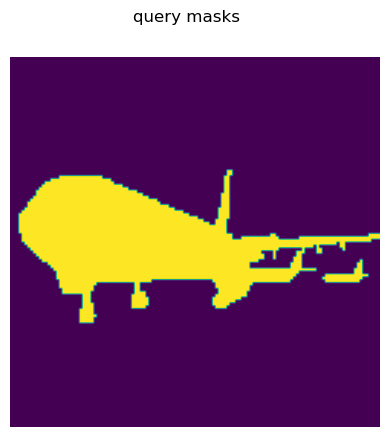

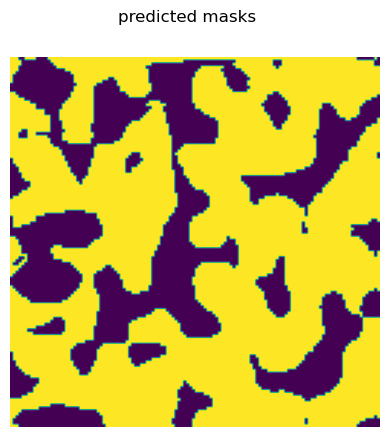

iteration 2
  batch 2 loss: 0.712195634841919


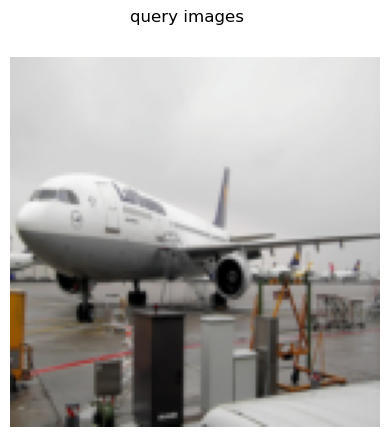

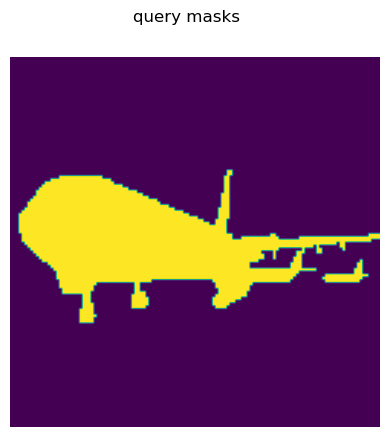

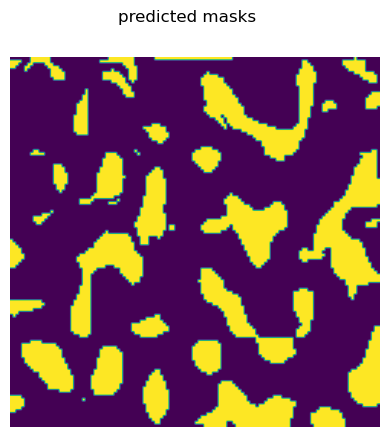

iteration 3
  batch 3 loss: 0.712195634841919


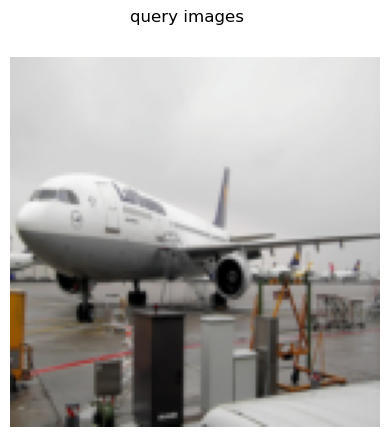

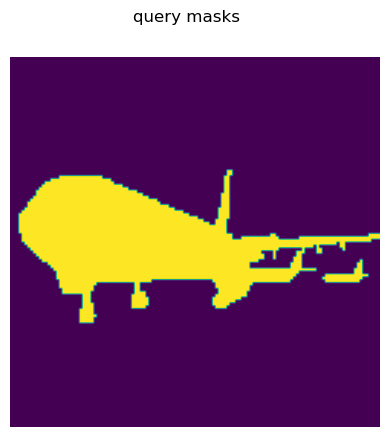

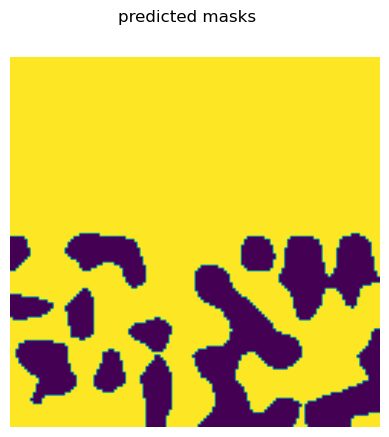

iteration 4
  batch 4 loss: 0.712195634841919


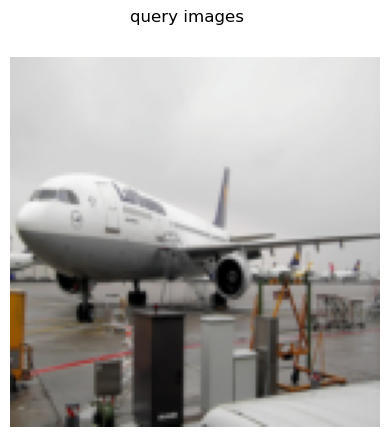

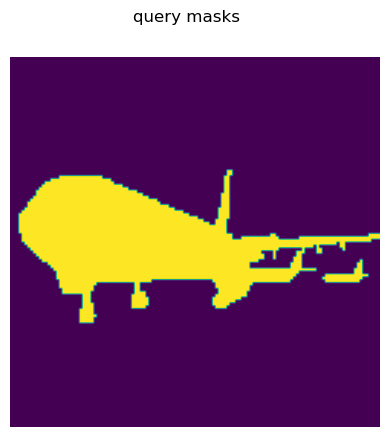

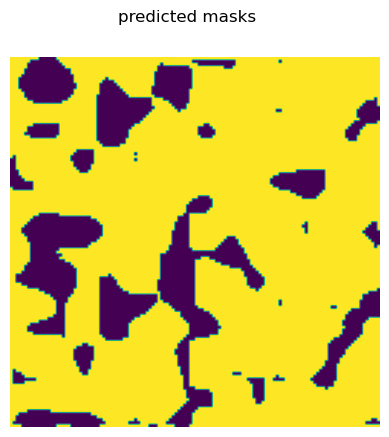

EPOCH 5:
iteration 1
  batch 1 loss: 0.712195634841919


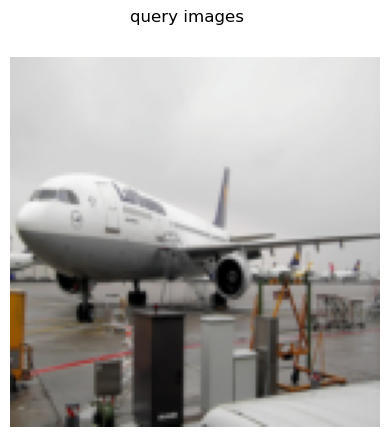

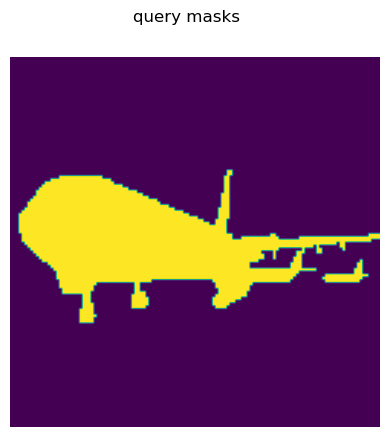

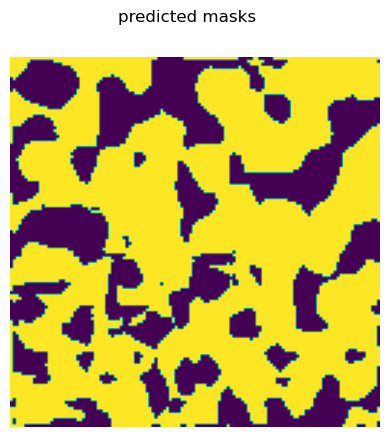

iteration 2
  batch 2 loss: 0.712195634841919


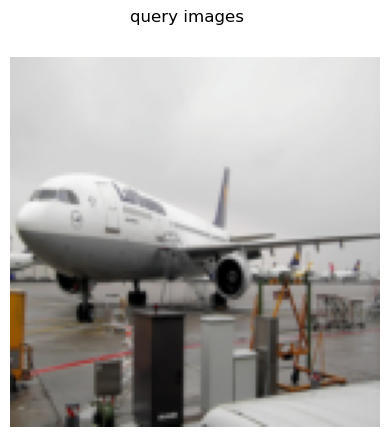

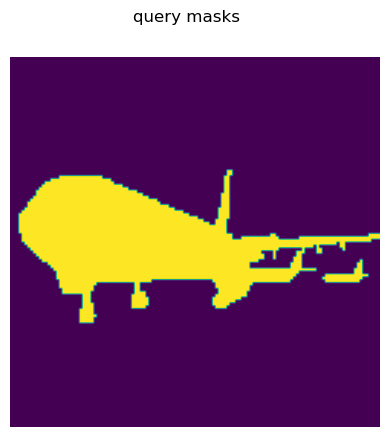

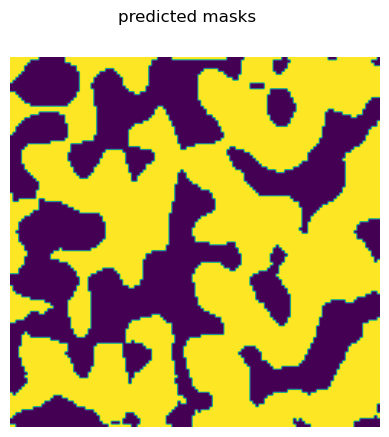

iteration 3
  batch 3 loss: 0.712195634841919


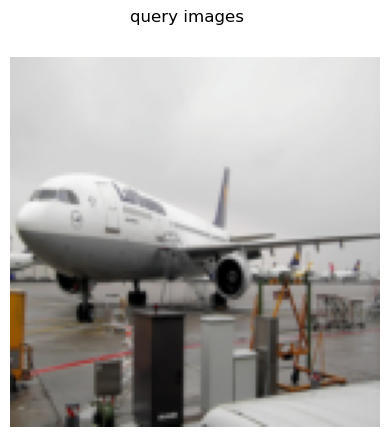

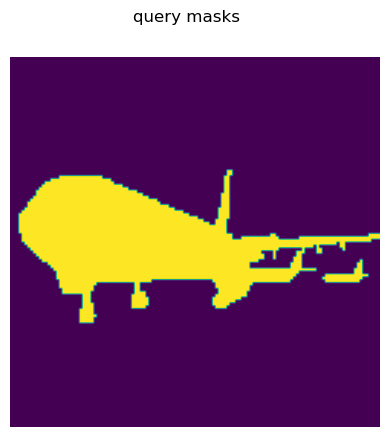

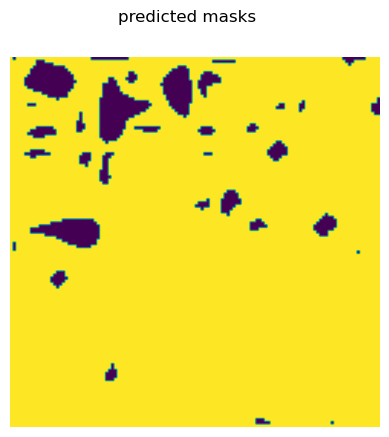

iteration 4


In [ ]:
if use_dice_loss:
    loss_fn = DiceLoss()
else:
    loss_fn = nn.BCEWithLogitsLoss()
    
    
train(
    model=model, 
    loss_fn=loss_fn, 
    optimizer=optimizer["adamw"], 
    num_epoch=num_epoch, 
    dataloader_trn=dataloader_trn, 
    dataloader_val=dataloader_val, 
    loss_batch=1,
    device = device,
    use_dice_loss=use_dice_loss,
    overfit = OVERFIT == 1
)

In [ ]:
from datetime import datetime
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = 'model_{}_{}'.format(timestamp, epoch_number)
torch.save(model, model_path)

## Visualization Test

In [32]:
""" Code below visualizes prediction (to be used in testing) 
    and declares evaluation metrics.
    
    DISCLAIMER: It is based on https://github.com/juhongm999/hsnet/tree/main

"""

Visualizer.initialize(True)
Evaluator.initialize()

average_meter = Metrics(device, num_class=20, dataset=FSSDataset.dataset)

vis_step = 100
for idx, batch in enumerate(dataloader_trn):

        # STEP 0: Get query image and support images with corresponding masks
        query_img = batch['query_img'].to(device)
        supp_imgs = batch['support_imgs'].to(device)
        supp_masks = batch['support_masks'].to(device)

        # STEP 1: Get predicted mask
        model.eval()
        pred_mask = model(query_img, supp_imgs, supp_masks, normalize=use_dice_loss)
        pred_mask = pred_mask.squeeze(1).cpu()
        assert pred_mask.size() == batch['query_mask'].size()

        # 2. Evaluate prediction
        area_inter, area_union = Evaluator.classify_prediction(pred_mask.clone(), batch)

        average_meter.update(area_inter, area_union, batch['class_id'], loss=None)

        # Visualize predictions
        if Visualizer.visualize:
            Visualizer.visualize_prediction_batch(batch['support_imgs'], batch['support_masks'],
                                                  batch['query_img'], batch['query_mask'],
                                                  pred_mask, batch['class_id'], idx,
                                                  area_inter[1].float() / area_union[1].float())

        if idx+1 == vis_step:
            break

miou, fb_iou = average_meter.compute_iou()
print("mIoU: ", miou)
print("FB-IoU: ", fb_iou)

mIoU:  tensor(2.5078)
FB-IoU:  tensor(43.1601)
